In [1]:
import numpy as np
import mujoco
import mediapy
import matplotlib.pyplot as plt
import time
import os

In [2]:
video_index = 0
def load_model_and_reset_data_from_xml(xml_string):
    mj_model = mujoco.MjModel.from_xml_string(xml_string)
    mj_data = mujoco.MjData(mj_model)

    mujoco.mj_resetData(mj_model, mj_data)
    return mj_data, mj_model
    # mj_data.joint('root').qvel = initial_qvel
def render(mj_data, mj_model, framerate=30, play_speed=1, num_frames=30 * 10, save_file_name = None, step_function=None):
    global video_index
    mj_renderer = mujoco.Renderer(mj_model)

    frames = []
    mujoco.mj_forward(mj_model, mj_data)
    for idx in range(num_frames):
        while mj_data.time * framerate / play_speed < idx:
            mujoco.mj_step(mj_model, mj_data)
            if step_function is not None:
                step_function(mj_model, mj_data)

        # mj_renderer.update_scene(mj_data, camera="fixed")
        mj_renderer.update_scene(mj_data, camera=0)
        frames.append(mj_renderer.render())

    mj_renderer.close()
    mediapy.show_video(frames, fps=framerate)
    video_index += 1
    if save_file_name is not None:
        path = os.path.join("result_videos", f"part3_{video_index:03d}_{save_file_name}")
        mediapy.write_video(path, frames, fps=framerate)

# equality

In [3]:
polycoefs = [[0, 1, 0, 0, 0], [0.1, 3, 0, 0, 0]]
for polycoef in polycoefs:
    mjcf_xml = f"""
    <mujoco>
    <option timestep=".001">
        <flag energy="enable" contact="disable"/>
    </option>

    <default>
        <joint type="hinge" axis="0 -1 0"/>
        <geom type="capsule" size=".02"/>
    </default>

    <contact>
        <exclude body1="coordinate_frame" body2="root_body"/>
    </contact>

    <equality>
        <!-- Joint equality constraint to connect joints -->
        <joint joint1="joint1" joint2="joint2" solimp="0.9 0.95 0.001" solref="0.02 1"/>
        <joint joint1="root" joint2="independent_root" solimp="0.9 0.95 0.001" solref="0.02 1" polycoef="{polycoef[0]} {polycoef[1]} {polycoef[2]} {polycoef[3]} {polycoef[4]}"/>
    </equality>

    <worldbody>
        <light pos="0 -.4 1"/>
        <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

        <!-- Add coordinate axes visualization -->
        <body name="coordinate_frame" pos="-0.4 0 -0.3">
            <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
            <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
            <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
        </body>

        <body name="root_body" pos="0 0 .2">
        <joint name="root"/>
        <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>

        <body name="pendulum_1" pos="0 0 -.25">
            <joint name="joint1"/>
            <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
        </body>
        </body>
        
        <!-- Second pendulum that will be constrained to move with the first -->
        <body name="independent_body" pos="0.3 0 .2">
        <joint name="independent_root"/>
        <geom fromto="0 0 0 0 0 -.25" rgba="1 0.5 0 1"/>

        <body name="pendulum_2" pos="0 0 -.25">
            <joint name="joint2"/>
            <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0.5 1"/>
        </body>
        </body>
    </worldbody>
    </mujoco>
    """

    mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
    mj_data.joint('root').qvel = 10
    # mj_data.joint('independent_root').qvel = -10
    render(mj_data, mj_model, num_frames=30 * 3, save_file_name=f"equality_joint_{polycoef}.mp4")




In [4]:
mjcf_xml = f"""
<mujoco>
<option timestep=".001">
    <flag energy="enable" contact="disable"/>
</option>

<default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
</default>

<contact>
    <exclude body1="coordinate_frame" body2="link1"/>
</contact>

<worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <body name="root_body" pos="0.2 0 0.2">
        <geom fromto="0 0 0 -0.4 0 0" rgba="1 1 0 1"/>


        <!-- First link -->
        <body name="link1" pos="-0.4 0 0">
            <joint name="joint1"/>
            <geom fromto="0 0 0 0 0 -0.3" rgba="1 0 0 1"/>

            <!-- Second link -->
            <body name="link2" pos="0 0 -0.3">
                <joint name="joint2"/>
                <geom fromto="0 0 0 0.4 0 0" rgba="0 1 0 1"/>

                <!-- Third link (will be constrained by connect equality) -->
                <body name="link3" pos="0.4 0 0">
                    <joint name="joint3"/>
                    <geom fromto="0 0 0 0 0 0.3" rgba="0 0 1 1"/>
                </body>
            </body>
        </body>
    </body>
    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.3">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>
</worldbody>

<equality>
    <!-- Connect link3 to root_body to create a loop joint -->
    <connect name="connect3" body1="link3" body2="root_body" anchor="0 0 0.3" solimp="0.9 0.95 0.001" solref="0.02 1"/>
</equality>
</mujoco>
"""

mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
mj_data.joint('joint1').qvel = 10
# mj_data.joint('independent_root').qvel = -10
render(mj_data, mj_model, num_frames=30 * 3, save_file_name=f"four_bar_link_loop.mp4")

In [5]:
mjcf_xml = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <contact>
    <exclude body1="coordinate_frame" body2="root_body"/>
  </contact>

  <equality>
    <!-- Joint equality constraint to connect joints -->
    <connect name="connect1" body1="pendulum_1" body2="root_body" anchor="0 0 0" solimp="0.9 0.95 0.001" solref="0.02 1"/>
  </equality>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.3">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>

    <body name="root_body" pos="0 0 0">
      
      <geom type="sphere" size="0.05" rgba="1 1 0 1"/>
    </body>

    <body name="pendulum_1" pos="0 0 0">
        <joint name="root" type="free"/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
    </body>
    
  </worldbody>
</mujoco>
"""

mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
mj_data.joint('root').qvel[:] = 10
# mj_data.joint('independent_root').qvel = -10
root_body_xpos = []
def step_funtion(mj_model, mj_data):
    root_body_xpos.append(mj_data.body('pendulum_1').xpos.copy())

render(mj_data, mj_model, play_speed=1, num_frames=30 * 3, step_function=step_funtion, save_file_name="equality_connect.mp4")




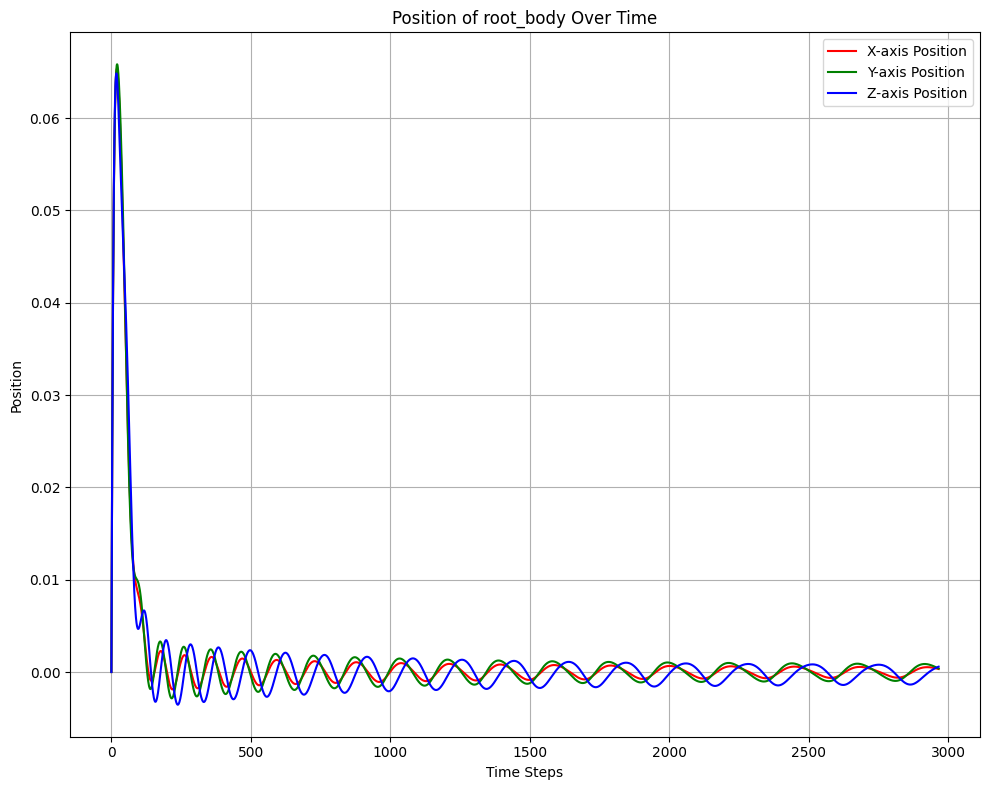

In [6]:
# Plot the trajectory of root_body
import matplotlib.pyplot as plt
import numpy as np

# Convert position data to numpy array for easier manipulation
root_body_np = np.array(root_body_xpos)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
time_steps = np.arange(len(root_body_xpos))

# Plot all three axes on the same plot with different colors
ax.plot(time_steps, root_body_np[:, 0], 'r-', label='X-axis Position')
ax.plot(time_steps, root_body_np[:, 1], 'g-', label='Y-axis Position')
ax.plot(time_steps, root_body_np[:, 2], 'b-', label='Z-axis Position')

ax.set_xlabel('Time Steps')
ax.set_ylabel('Position')
ax.set_title('Position of root_body Over Time')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [7]:
mjcf_xml = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <contact>
    <exclude body1="coordinate_frame" body2="root_body"/>
  </contact>

  <equality>
    <!-- Joint equality constraint to connect joints -->
    <connect name="connect1" body1="pendulum_1" body2="root_body" anchor="0 0 0" solimp="0.9 0.95 0.001" solref="0.02 1"/>
  </equality>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.3">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>

    <body name="root_body" pos="0 0 0">
      
      <geom type="sphere" size="0.05" rgba="1 1 0 1"/>

      <body name="pendulum_1" pos="0 0 0">
        <joint name="root" type="ball"/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
    </body>
    </body>

    
    
  </worldbody>
</mujoco>
"""

mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
mj_data.joint('root').qvel[:] = 10
# mj_data.joint('independent_root').qvel = -10
root_body_xpos = []
def step_funtion(mj_model, mj_data):
    root_body_xpos.append(mj_data.body('pendulum_1').xpos.copy())

render(mj_data, mj_model, play_speed=1, num_frames=30 * 3, step_function=step_funtion, save_file_name="without_equality_joint.mp4")




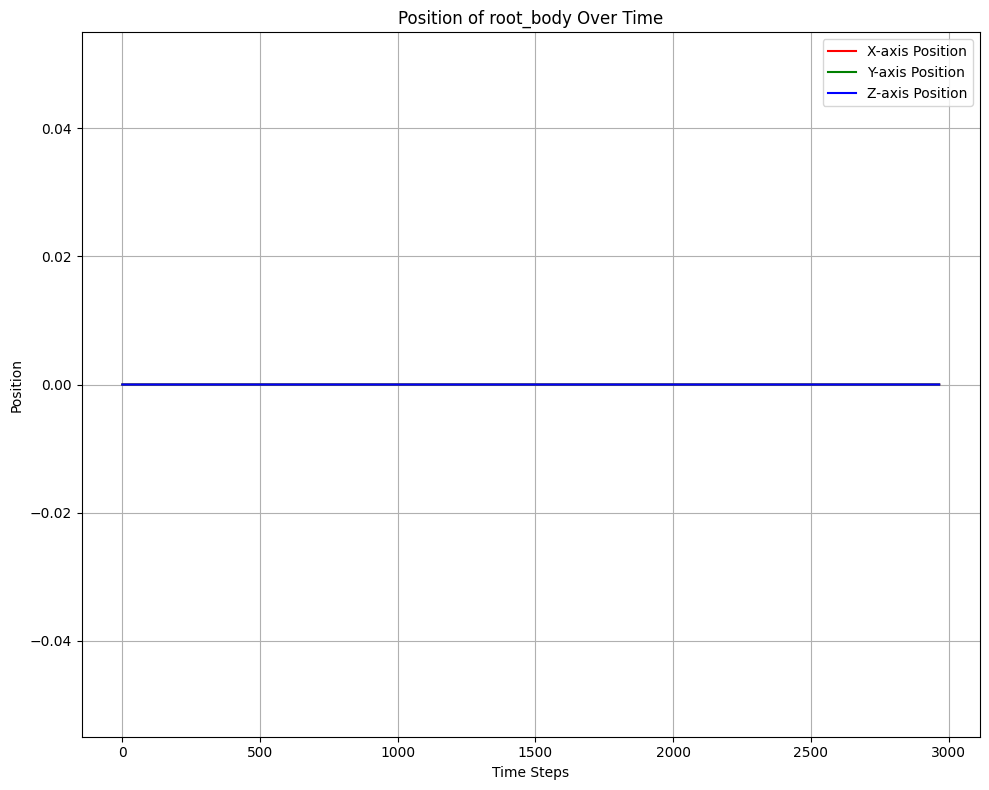

In [8]:
# Plot the trajectory of root_body
import matplotlib.pyplot as plt
import numpy as np

# Convert position data to numpy array for easier manipulation
root_body_np = np.array(root_body_xpos)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
time_steps = np.arange(len(root_body_xpos))

# Plot all three axes on the same plot with different colors
ax.plot(time_steps, root_body_np[:, 0], 'r-', label='X-axis Position')
ax.plot(time_steps, root_body_np[:, 1], 'g-', label='Y-axis Position')
ax.plot(time_steps, root_body_np[:, 2], 'b-', label='Z-axis Position')

ax.set_xlabel('Time Steps')
ax.set_ylabel('Position')
ax.set_title('Position of root_body Over Time')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [9]:
stiffness1 = 10
damping1 = 0.5
hinge_stiffness1 = 0.1
hinge_damping1 = 0.0

stiffness2 = 10
damping2 = 0.5
hinge_stiffness2 = 0.1
hinge_damping2 = 0.0

stiffness3 = 10
damping3 = 0.5
hinge_stiffness3 = 0.1
hinge_damping3 = 0.0

mjcf_xml_weld = f"""
<mujoco>
    <compiler angle="radian"/>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -2 -0.5" xyaxes="1 0 0 0 0 1"/>

    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.03">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>

    <!-- First pendulum 1 (double pendulum) -->
    <body name="pendulum1" pos="0 0 0">
      <joint name="joint1"/>
      <geom name="rod1" fromto="0 0 0 0 0 -0.5" rgba="1 1 0 1" mass = "1"/>
      <body name="pendulum1_lower" pos="0 0 -0.5">
        <joint name="joint1_lower"/>
        <geom name="rod1_lower" fromto="0 0 0 0 0 -0.5" rgba="1 0.5 0 1"/>
        <body name="weight1" pos="0 0 -0.5">
            <geom type="sphere" size=".05" rgba="1 0 0 1" mass="1"/>
            <!-- Exo -->
            <body name="weight1_exo" pos="0 0 0">
                <geom type="box" size=".06 .06 .06" rgba="1 0 1 1" mass="0.1"/>
                <geom type="capsule" size="0.003" rgba="1 0 0 1" mass="0" fromto="0 0 0 0.25 0 0"/>
                <geom type="capsule" size="0.003" rgba="0 1 0 1" mass="0" fromto="0 0 0 0 0.25 0"/>
                <geom type="capsule" size="0.003" rgba="0 0 1 1" mass="0" fromto="0 0 0 0 0 0.25"/>
                <joint type="slide" axis="0 0 1" stiffness="{stiffness1}" damping="{damping1}" range="-0.01 0.01" ref="0"/>
                <joint type="slide" axis="0 1 0" stiffness="{stiffness1}" damping="{damping1}" range="-0.01 0.01" ref="0"/>
                <joint type="slide" axis="1 0 0" stiffness="{stiffness1}" damping="{damping1}" range="-0.01 0.01" ref="0"/>
                <joint name="springdamperrz" axis="0 0 1" stiffness="{hinge_stiffness1}" damping="{hinge_damping1}" ref="0"/>
                <joint name="springdamperry" axis="0 1 0" stiffness="{hinge_stiffness1}" damping="{hinge_damping1}" ref="0"/>
                <joint name="springdamperrx" axis="1 0 0" stiffness="{hinge_stiffness1}" damping="{hinge_damping1}" ref="0"/>
                <body name = "weight2_child" pos="0 0 0.25">
                    <geom name="rod2" type="box" size="0.06 0.06 0.06" pos="0 0 0" rgba="0 1 0 1" mass="0.1"/>
                    <geom type="capsule" size="0.003" rgba="1 0 0 1" mass="0" fromto="0 0 0 0.25 0 0"/>
                    <geom type="capsule" size="0.003" rgba="0 1 0 1" mass="0" fromto="0 0 0 0 0.25 0"/>
                    <geom type="capsule" size="0.003" rgba="0 0 1 1" mass="0" fromto="0 0 0 0 0 0.25"/>

                    <joint type="slide" axis="0 1 0" stiffness="{stiffness2}" damping="{damping2}" range="-0.01 0.01" ref="0"/>
                    <joint type="slide" axis="1 0 0" stiffness="{stiffness2}" damping="{damping2}" range="-0.01 0.01" ref="0"/>
                    <joint name="springdamperrz2" axis="0 0 1" stiffness="{hinge_stiffness2}" damping="{hinge_damping2}" ref="0"/>
                    <joint name="springdamperry2" axis="0 1 0" stiffness="{hinge_stiffness2}" damping="{hinge_damping2}" ref="0"/>
                    <joint name="springdamperrx2" axis="1 0 0" stiffness="{hinge_stiffness2}" damping="{hinge_damping2}" ref="0"/>

                    <body name="weight2_child_constraint" pos="0 0 0">
                        <joint type="slide" axis="0 0 1" stiffness="{stiffness3}" damping="{damping3}" range="-0.1 0.1" ref="0"/>
                        <joint type="slide" axis="0 1 0" stiffness="{stiffness3}" damping="{damping3}" range="-0.1 0.1" ref="0"/>
                        <joint type="slide" axis="1 0 0" stiffness="{stiffness3}" damping="{damping3}" range="-0.03 0.03" ref="0"/>
                        <joint name="springdamperrz3" axis="0 0 1" stiffness="{hinge_stiffness3}" damping="{hinge_damping3}" ref="0"/>
                        <joint name="springdamperry3" axis="0 1 0" stiffness="{hinge_stiffness3}" damping="{hinge_damping3}" ref="0"/>
                        <joint name="springdamperrx3" axis="1 0 0" stiffness="{hinge_stiffness3}" damping="{hinge_damping3}" ref="0"/>
                        <!--mass should not be super small (underflow?)-->
                        <geom type="box" size=".03 .03 .03" rgba="0 1 1 1" mass="0.001"/>
                    </body>
                </body>
            </body>
        </body>
      </body>
    </body>
    
    <!-- pendulum 2 -->
    
  </worldbody>
  
  <!-- Equality constraints section using weld -->
  <equality>
    <!-- Weld the two pendulum weights together with a fixed relative position -->
    <weld body1="pendulum1_lower" body2="weight2_child_constraint" solimp="0.9 0.95 0.001" solref="0.02 1"/>
  </equality>
</mujoco>
"""

mj_data_weld, mj_model_weld = load_model_and_reset_data_from_xml(mjcf_xml_weld)

# Set initial velocity to the first pendulum
mj_data_weld.joint('joint1').qpos = 0.3
# mj_data_weld.joint('springdamperrx').qpos = 0.3
# mj_data_weld.joint('springdamperry').qpos = 0.3
mj_data_weld.joint('springdamperrz').qpos = 1
mj_data_weld.joint('springdamperrz2').qpos = 1
mj_data_weld.joint('springdamperrz3').qpos = 1

# Render the simulation with weld constraint
render(mj_data_weld, mj_model_weld, play_speed=1, num_frames=30 * 5, save_file_name="weld_equality_constraint_with_springdamper.mp4")

# Kinematics

## When weight_2 is fixed child of weight_1

In [10]:
mjcf_xml = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <contact>
        <exclude body1="coordinate_frame" body2="root_body"/>
    </contact>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.3">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>

    <body name="root_body" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>


      <body name="pendulum_1" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
        <body name="weight_1" pos="0 0 -.25">
            <geom type="sphere" size="0.05" rgba="0 0 1 1"/>
            <body name="weight_2" pos="0 0 0">
                <geom type="sphere" size="0.05" rgba="1 0 0 1" mass="1000000"/>
            </body>
        </body>
      </body>
    </body>
  </worldbody>
</mujoco>
"""

mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
mj_data.joint('root').qvel = 1

weight_1_xpos = []
weight_2_xpos = []
def step_funtion(mj_model, mj_data):
    weight_1_xpos.append(mj_data.body('weight_1').xpos.copy())
    weight_2_xpos.append(mj_data.body('weight_2').xpos.copy())

render(mj_data, mj_model, play_speed=1, num_frames=30 * 3, step_function=step_funtion, save_file_name="pendulum_kinematic.mp4")



In [11]:
max_diff = 0
for i in range(len(weight_1_xpos)):
    diff = weight_1_xpos[i] - weight_2_xpos[i]
    diff_len = np.linalg.norm(diff)
    if diff_len > max_diff:
        max_diff = diff_len
print(max_diff)


0


## what if there is more 

In [12]:
mjcf_xml = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <contact>
        <exclude body1="coordinate_frame" body2="root_body"/>
    </contact>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.3">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>

    <body name="root_body" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>


      <body name="pendulum_1" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
        <body name="weight_1" pos="0 0 -.25">
            <geom type="sphere" size="0.05" rgba="0 0 1 1"/>
            <body name="weight_2" pos="0 0 0">
                <joint axis="0 0 1" range="-0.01 0.01" ref="0"/>
                <joint axis="0 1 0" range="-0.01 0.01" ref="0"/>
                <joint axis="1 0 0" range="-0.01 0.01" ref="0"/>

                <geom type="sphere" size="0.05" rgba="1 0 0 1" mass="100"/>
            </body>
        </body>
      </body>
    </body>
  </worldbody>
</mujoco>
"""

mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
mj_data.joint('root').qvel = 1

weight_1_xpos = []
weight_2_xpos = []
def step_funtion(mj_model, mj_data):
    weight_1_xpos.append(mj_data.body('weight_1').xpos.copy())
    weight_2_xpos.append(mj_data.body('weight_2').xpos.copy())

render(mj_data, mj_model, play_speed=1, num_frames=30 * 3, step_function=step_funtion, save_file_name="pendulum_kinematic_plus_hinge3.mp4")




In [13]:
max_diff = 0
for i in range(len(weight_1_xpos)):
    diff = weight_1_xpos[i] - weight_2_xpos[i]
    diff_len = np.linalg.norm(diff)
    if diff_len > max_diff:
        max_diff = diff_len
print(max_diff)


0


In [14]:
mjcf_xml = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <contact>
        <exclude body1="coordinate_frame" body2="root_body"/>
    </contact>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <!-- Add coordinate axes visualization -->
    <body name="coordinate_frame" pos="-0.4 0 -0.3">
        <geom name="x_axis" type="capsule" fromto="0 0 0 0.2 0 0" size="0.004" rgba="1 0 0 1"/>  <!-- Red for X axis -->
        <geom name="y_axis" type="capsule" fromto="0 0 0 0 0.2 0" size="0.004" rgba="0 1 0 1"/>  <!-- Green for Y axis -->
        <geom name="z_axis" type="capsule" fromto="0 0 0 0 0 0.2" size="0.004" rgba="0 0 1 1"/>  <!-- Blue for Z axis -->
    </body>

    <body name="root_body" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>


      <body name="pendulum_1" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
        <body name="weight_1" pos="0 0 -.25">
            <geom type="sphere" size="0.05" rgba="0 0 1 1"/>
            
        </body>
      </body>
    </body>

    <body name="weight_2" pos="0 0 -0.3">
        <joint type="free"/>
        <geom type="sphere" size="0.05" rgba="1 0 0 1" mass="1"/>
    </body>
  </worldbody>

  <equality>
    <weld body1="weight_1" body2="weight_2" solimp="0.9 0.95 0.001" solref="0.02 1"/>
  </equality>
</mujoco>
"""

mj_data, mj_model = load_model_and_reset_data_from_xml(mjcf_xml)
mj_data.joint('root').qvel = 10

weight_1_xpos = []
weight_2_xpos = []
def step_funtion(mj_model, mj_data):
    weight_1_xpos.append(mj_data.body('weight_1').xpos.copy())
    weight_2_xpos.append(mj_data.body('weight_2').xpos.copy())

render(mj_data, mj_model, play_speed=1, num_frames=30 * 3, step_function=step_funtion, save_file_name="pendulum_weld.mp4")



0.03281059897001688
0.0


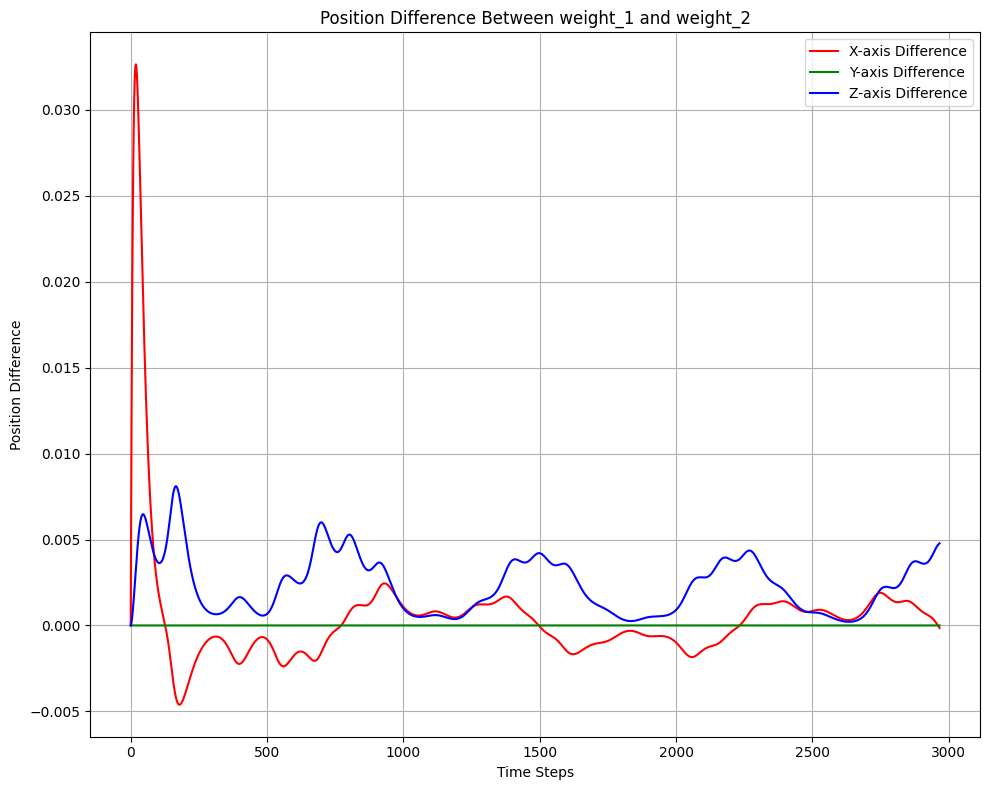

In [15]:
max_diff = 0
min_diff = np.inf
diff_array = []
for i in range(len(weight_1_xpos)):
    diff = weight_1_xpos[i] - weight_2_xpos[i]
    diff_len = np.linalg.norm(diff)
    diff_array.append(diff_len)
    if diff_len > max_diff:
        max_diff = diff_len
    if diff_len < min_diff:
        min_diff = diff_len
print(max_diff)
print(min_diff)

# Plot the difference between weight_1 and weight_2 positions for each axis
import matplotlib.pyplot as plt

# Convert position data to numpy arrays for easier manipulation
weight_1_np = np.array(weight_1_xpos)
weight_2_np = np.array(weight_2_xpos)

# Calculate difference for each axis
diff_x = weight_1_np[:, 0] - weight_2_np[:, 0]
diff_y = weight_1_np[:, 1] - weight_2_np[:, 1]
diff_z = weight_1_np[:, 2] - weight_2_np[:, 2]

# Create figure with 3 subplots (one for each axis)
fig, ax = plt.subplots(figsize=(10, 8))
time_steps = np.arange(len(diff_x))

# Plot all three axes on the same plot with different colors
ax.plot(time_steps, diff_x, 'r-', label='X-axis Difference')
ax.plot(time_steps, diff_y, 'g-', label='Y-axis Difference')
ax.plot(time_steps, diff_z, 'b-', label='Z-axis Difference')

ax.set_xlabel('Time Steps')
ax.set_ylabel('Position Difference')
ax.set_title('Position Difference Between weight_1 and weight_2')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()
